In [17]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional



In [10]:
%store -r data
train = data[data.year < 2019]
valid = data[data.year >= 2019]
train.columns
%store -r data_x
features = data_x.columns


In [11]:
X_train, X_valid, Y_train, Y_valid=train[features], valid[features], train["wind_generation_actual"], valid["wind_generation_actual"]
X_train, X_valid = np.array(X_train), np.array(X_valid)

X_train_array = np.asarray(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])))
X_valid_array = np.asarray(X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1]))
Y_train_array = np.asarray(Y_train) 
Y_valid_array = np.asarray(Y_valid)

In [12]:
lstm_model = Sequential([
    Bidirectional(LSTM(100, activation = "relu", return_sequences=False, input_shape=(1, X_train_array.shape[2]))),
    Dense(8, activation="relu"),
    Dense(1)

    ])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.001),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [13]:
history = lstm_model.fit(X_train_array, Y_train_array, 
     validation_data=(X_valid_array, Y_valid_array),
     epochs=150, verbose=2, batch_size = 128)

Epoch 1/150
12/12 - 3s - loss: 86806380544.0000 - root_mean_squared_error: 294629.2188 - val_loss: 141159006208.0000 - val_root_mean_squared_error: 375711.3438 - 3s/epoch - 210ms/step
Epoch 2/150
12/12 - 0s - loss: 76861980672.0000 - root_mean_squared_error: 277239.9375 - val_loss: 118823460864.0000 - val_root_mean_squared_error: 344707.7812 - 84ms/epoch - 7ms/step
Epoch 3/150
12/12 - 0s - loss: 57447190528.0000 - root_mean_squared_error: 239681.4375 - val_loss: 69748408320.0000 - val_root_mean_squared_error: 264099.2500 - 88ms/epoch - 7ms/step
Epoch 4/150
12/12 - 0s - loss: 26788931584.0000 - root_mean_squared_error: 163673.2500 - val_loss: 22033825792.0000 - val_root_mean_squared_error: 148437.9531 - 60ms/epoch - 5ms/step
Epoch 5/150
12/12 - 0s - loss: 9835649024.0000 - root_mean_squared_error: 99174.8438 - val_loss: 10057049088.0000 - val_root_mean_squared_error: 100284.8359 - 61ms/epoch - 5ms/step
Epoch 6/150
12/12 - 0s - loss: 6738867200.0000 - root_mean_squared_error: 82090.6016 

In [14]:
lstmforecast = lstm_model.predict(X_valid_array)
valid["Forecast_LSTM"] = lstmforecast

12/12 [==============================] - 0s 1ms/step


/tmp/ipykernel_297519/2043689025.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Forecast_LSTM"] = lstmforecast


<AxesSubplot:>

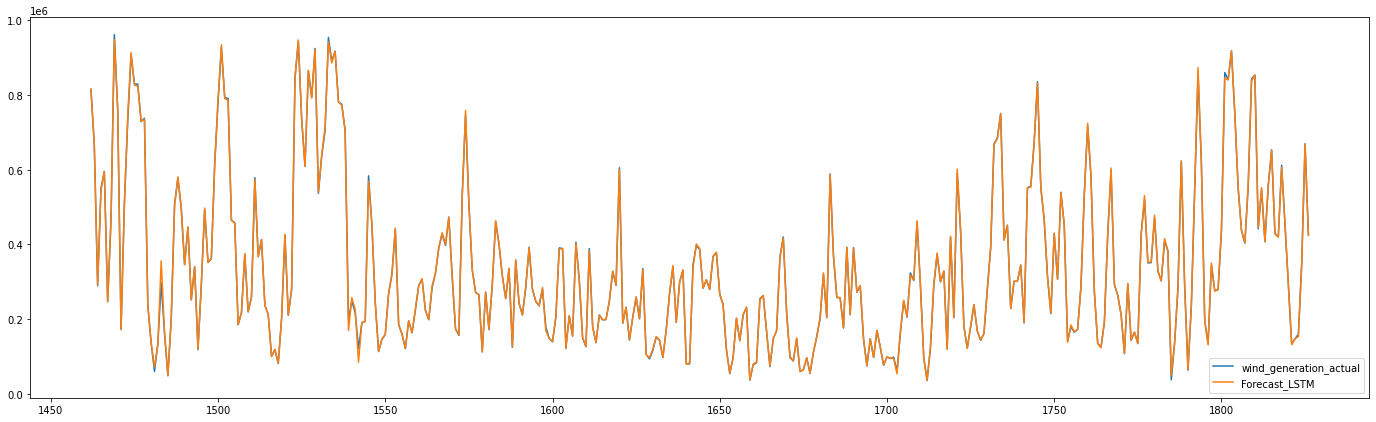

In [19]:
valid[["wind_generation_actual", "Forecast_LSTM"]].plot(figsize=(24, 7))

In [18]:
lstm_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_LSTM))
lstm_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_LSTM)

print("RMSE of LSTM:", lstm_rmse)
print("\nMAE of LSTM:", lstm_mae)

RMSE of LSTM: 5142.884045017621

MAE of LSTM: 2406.429901541096


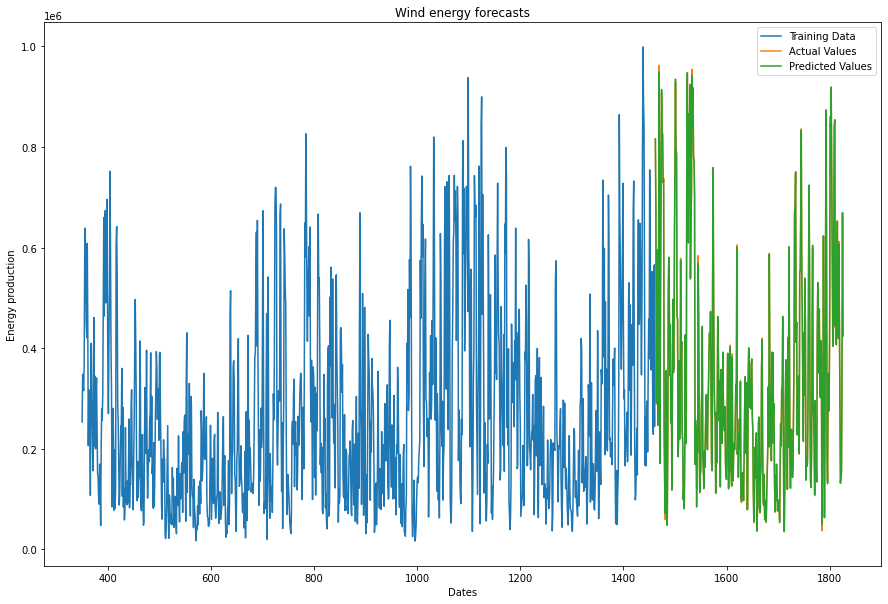

In [20]:
fig, axes = plt.subplots(figsize=(15, 10))

axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
axes.plot(valid.index, lstmforecast,label='Predicted Values')
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend()